# 1. Importing Modules

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

# 2. Loading The Dataset

In [2]:
cursor = sqlite3.connect(r'../database/laptrack.db')

laptop_df = pd.read_sql_query("SELECT * FROM Laptop_Phase_2_2", cursor)

cursor.close()

laptop_df.head()

,Brand,Laptop_Model_Name,Laptop_Model_Number,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_Life(Hours_Upto),...,Stock,Time_Of_Extraction,URL,Source,Storage_Capacity(GB),Display_Size(Inches),RAM(GB),No_Of_Reviews,Laptop_Dimensions,Laptop_Weight(Pounds)
0,Dell,Latitude 3540 Laptop,None,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,NaN,NaN,...,1,2024-11-04 18:23:39,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4000,15.6,64,0,0.71 x 14.13 x 9.44 inches,4.00
1,HP,17t-cn3004,17t-cn3004208,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.0,NaN,...,1,2024-11-04 18:23:42,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,17.3,64,0,0.81 x 10.15 x 15.78 inches,5.00
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",None,Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,NaN,NaN,...,1,2024-11-04 18:23:45,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,15.6,32,0,9.25 x 0.75 x 14.11 inches,3.60
3,Apple,MacBook Pro,Mvvm2ll/a,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.0,11.0,...,1,2024-11-04 18:23:54,https://www.amazon.com/2019-Apple-MacBook-16-i...,Amazon,2048,16.0,16,0,15.63 x 2.40 x 11.14 inches,5.68
4,HP,TPN-Q279,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.8,NaN,...,1,2024-11-04 18:23:57,https://www.amazon.com/HP-i7-1355U-i5-14400F-G...,Amazon,2048,15.6,16,0,0.93 x 10.04 x 14.09 inches,7.39


# 3. Preparing the dataset for Model Building

In [3]:
# Define columns for each type
categorical_cols = ['Brand', 'Processor_Brand', 'Operating_System', 'Storage_Type', 'Processor_Model']
numerical_cols = ['Extracted_Rating', 'Storage_Capacity(GB)', 'Display_Size(Inches)', 'RAM(GB)', 'No_Of_Reviews', 'Laptop_Weight(Pounds)', 'Price']

decidingColumns = categorical_cols + numerical_cols
decidingColumns.append('Stock')

In [4]:
numerical_imputer = SimpleImputer(strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numerical_imputer), 
            ('scaler', RobustScaler()) 
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# 4. Model Building

In [5]:
# Lists to store prediction of each model and the trained model object
y_pred_reg_models = []
reg_model = []

## 4.1 KNN Regressor

In [6]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# Define columns
KNNcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
KNNnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
KNN_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = KNN_df_cleaned[KNNcategorical_cols + KNNnumerical_cols[:-1]]  # Exclude Price from features
y = KNN_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), KNNnumerical_cols[:-1]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), KNNcategorical_cols)
    ]
)

# Create the KNN Regression pipeline
knn_regressor = KNeighborsRegressor(n_neighbors=5)

KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', knn_regressor)
])

# Fit the pipeline on the training data
KNN_pipeline.fit(X_train, y_train)

# Predict on the test set
KNN_y_pred = KNN_pipeline.predict(X_test)

# Calculate RMSE
KNN_mse = mean_squared_error(y_test, KNN_y_pred)
KNN_rmse = np.sqrt(KNN_mse)

r2 = r2_score(y_test, KNN_y_pred)  # Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({ 'Predicted Values': KNN_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [KNN_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

In [7]:
results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,302.820,299.00,388.401803,0.640226,0.637634
1,446.064,455.88,388.401803,0.640226,0.637634
2,407.150,407.15,388.401803,0.640226,0.637634
3,897.792,899.99,388.401803,0.640226,0.637634
4,435.086,407.99,388.401803,0.640226,0.637634
...,...,...,...,...,...
835,296.006,169.99,388.401803,0.640226,0.637634
836,717.562,569.00,388.401803,0.640226,0.637634
837,235.398,202.79,388.401803,0.640226,0.637634
838,1615.990,1299.99,388.401803,0.640226,0.637634


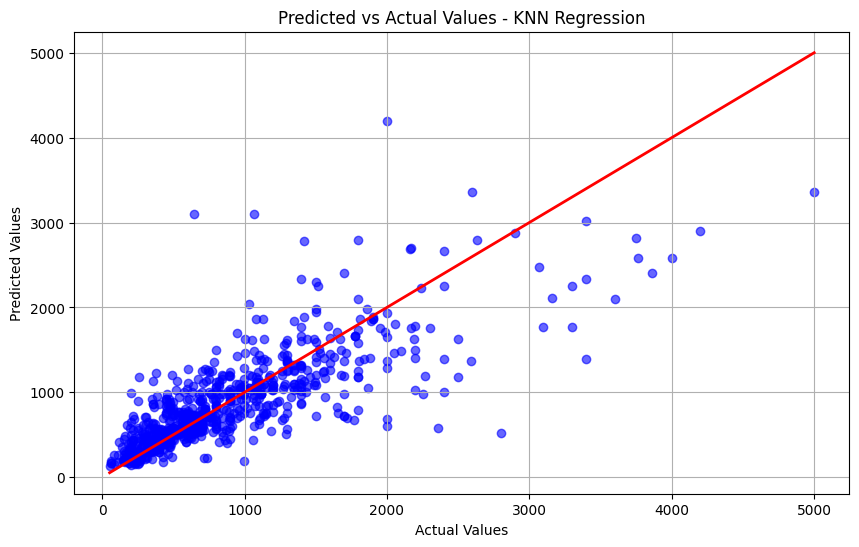

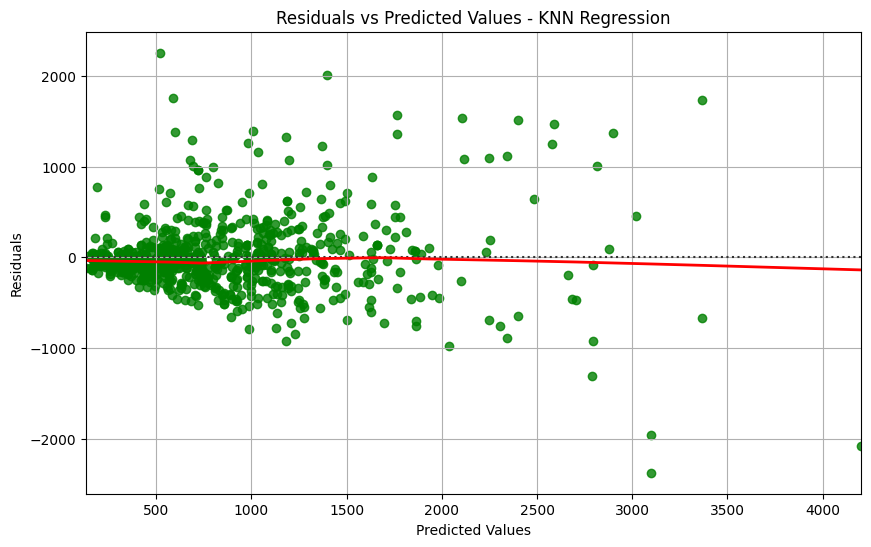

In [8]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, KNN_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - KNN Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - KNN_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=KNN_y_pred, y=residuals, lowess=True, color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - KNN Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [9]:
y_pred_reg_models.append(KNN_y_pred)

In [10]:
reg_model.append(knn_regressor)

## 4.2 Decision Tree Regressor

In [11]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Define categorical and numerical columns
DTcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
DTnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
DT_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = DT_df_cleaned[DTcategorical_cols + DTnumerical_cols[:-1]]  # Exclude Price from features
y = DT_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), DTnumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), DTcategorical_cols)
    ]
)

# Create the Decision Tree pipeline
decision_tree_regressor = DecisionTreeRegressor(random_state=42)

DT_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', decision_tree_regressor)
])

# Fit the pipeline on the training data
DT_pipeline.fit(X_train, y_train)

# Predict on the test set
DT_y_pred = DT_pipeline.predict(X_test)

# Calculate RMSE
DT_mse = mean_squared_error(y_test, DT_y_pred)
DT_rmse = np.sqrt(DT_mse)

r2 = r2_score(y_test, KNN_y_pred)  # Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({ 'Predicted Values': DT_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [DT_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })


In [12]:
results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,300.516667,299.00,402.036323,0.640226,0.637634
1,448.811860,455.88,402.036323,0.640226,0.637634
2,407.150000,407.15,402.036323,0.640226,0.637634
3,937.767273,899.99,402.036323,0.640226,0.637634
4,394.790000,407.99,402.036323,0.640226,0.637634
...,...,...,...,...,...
835,169.990000,169.99,402.036323,0.640226,0.637634
836,724.743182,569.00,402.036323,0.640226,0.637634
837,294.350000,202.79,402.036323,0.640226,0.637634
838,1499.990000,1299.99,402.036323,0.640226,0.637634


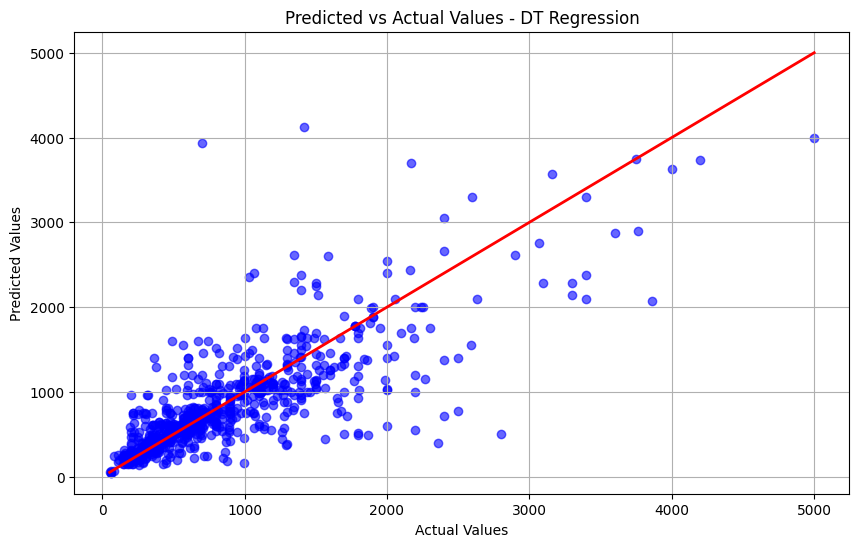

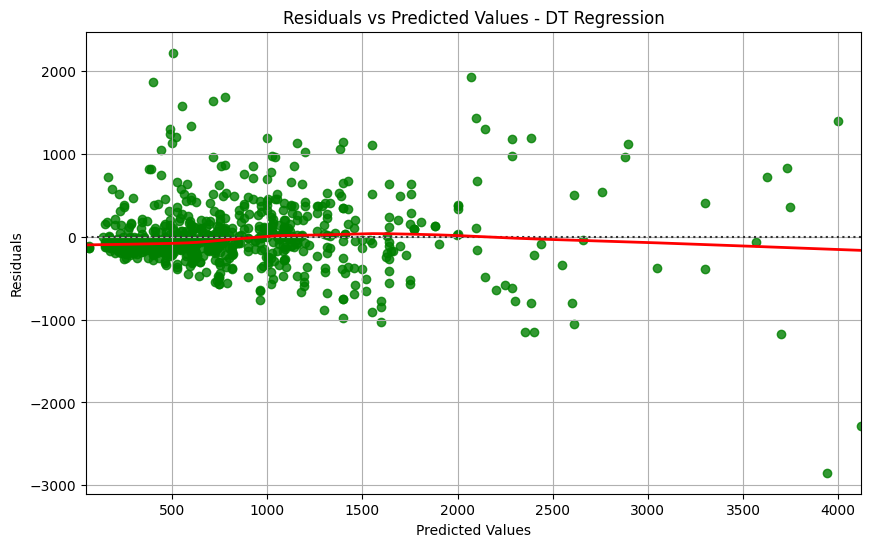

In [13]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, DT_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - DT Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - DT_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=DT_y_pred, y=residuals, lowess=True, color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - DT Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [14]:
y_pred_reg_models.append(DT_y_pred)

In [15]:
reg_model.append(decision_tree_regressor)

## 4.3 Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression


categorical_cols = ['Brand', 'Processor_Brand', 'Operating_System', 'Storage_Type', 'Processor_Model']
numerical_cols = ['Extracted_Rating', 'Storage_Capacity(GB)', 'Display_Size(Inches)', 'RAM(GB)', 'No_Of_Reviews', 'Laptop_Weight(Pounds)', 'Price']

laptop_df = laptop_df.dropna(subset=['Price'])

X = laptop_df[categorical_cols + numerical_cols[:-1]]  # Exclude Price from features
y = laptop_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_cols[:-1]),  # Exclude 'Price'
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

LR_regressor = LinearRegression()

LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LR_regressor)
])

LR_pipeline.fit(X_train, y_train)

LR_y_pred = LR_pipeline.predict(X_test)

LR_mse = mean_squared_error(y_test, LR_y_pred)
LR_rmse = np.sqrt(LR_mse)

r2 = r2_score(y_test, LR_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({ 'Predicted Values': LR_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [LR_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

In [17]:
results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,233.865352,299.00,386.178406,0.644333,0.639608
1,454.369486,455.88,386.178406,0.644333,0.639608
2,391.036267,407.15,386.178406,0.644333,0.639608
3,1165.453880,899.99,386.178406,0.644333,0.639608
4,383.290239,407.99,386.178406,0.644333,0.639608
...,...,...,...,...,...
835,166.090827,169.99,386.178406,0.644333,0.639608
836,776.490982,569.00,386.178406,0.644333,0.639608
837,217.819980,202.79,386.178406,0.644333,0.639608
838,1599.344474,1299.99,386.178406,0.644333,0.639608


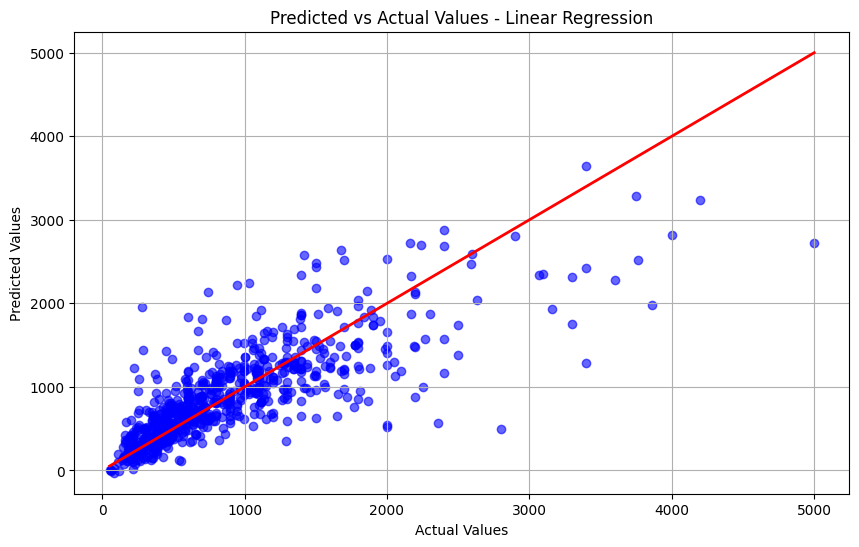

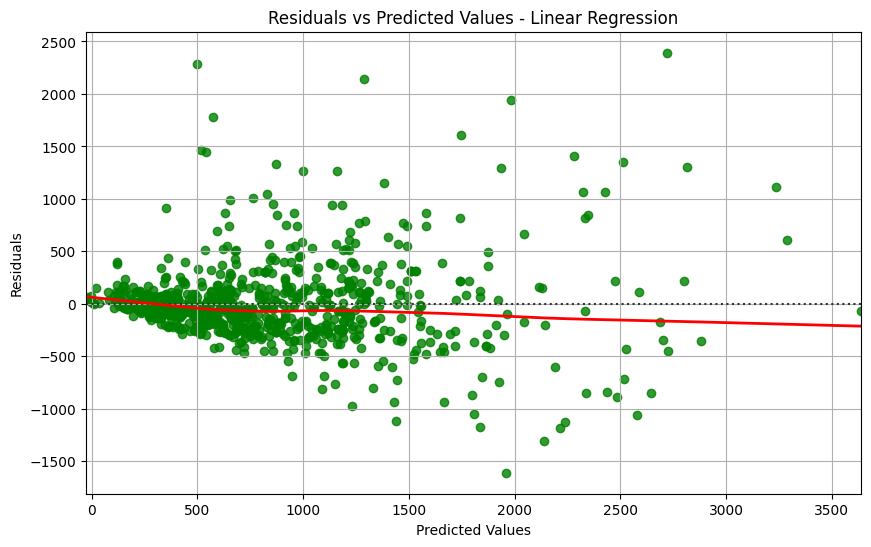

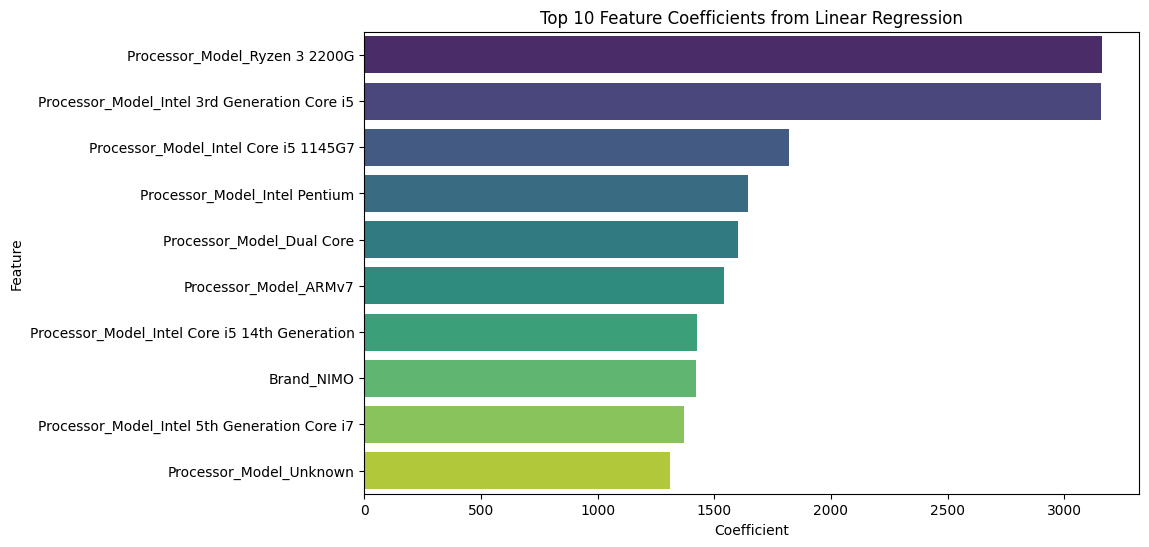

In [18]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, LR_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - Linear Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - LR_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=LR_y_pred, y=residuals, lowess=True,color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Feature Coefficients Plot (for Linear Regression)
coefficients = LR_pipeline.named_steps['regressor'].coef_

# Get the feature names from one-hot encoding (including numerical features)
cat_feature_names = LR_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([cat_feature_names, numerical_cols[:-1]])

# Prepare a DataFrame for better visualization of feature importance
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Number of top features to display
top_n = 10  

# Sort the coefficients by absolute value and get the top N features
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
top_coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(top_n)

# Plot top feature coefficients (importance)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coef_df, palette='viridis')
plt.title(f"Top {top_n} Feature Coefficients from Linear Regression")
plt.show()

In [19]:
coef_df

,Feature,Coefficient,Absolute_Coefficient
417,Processor_Model_Ryzen 3 2200G,3162.099344,3162.099344
323,Processor_Model_Intel 3rd Generation Core i5,3156.425043,3156.425043
362,Processor_Model_Intel Core i5 1145G7,1818.924983,1818.924983
378,Processor_Model_Intel Pentium,1646.365230,1646.365230
303,Processor_Model_Dual Core,1600.439090,1600.439090
...,...,...,...
45,Brand_MICROSOFT,-834.096666,834.096666
180,Processor_Model_1155g7,-874.920174,874.920174
158,Operating_System_macOS Monterey 12,-972.873468,972.873468
62,Brand_Razer,-1059.798391,1059.798391


In [20]:
y_pred_reg_models.append(LR_y_pred)

In [21]:
reg_model.append(LR_regressor)

## 4.4 Ridge Regression

In [22]:
# Ridge Regression
from sklearn.linear_model import Ridge

# Define categorical and numerical columns
Ridgecategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
Ridgenumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
Ridge_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = Ridge_df_cleaned[Ridgecategorical_cols + Ridgenumerical_cols[:-1]]  # Exclude Price from features
y = Ridge_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), Ridgenumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), Ridgecategorical_cols)
    ]
)

# Create the Ridge Regression pipeline
ridge_regressor = Ridge(alpha=1.0)

Ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_regressor)
])

# Fit the pipeline on the training data
Ridge_pipeline.fit(X_train, y_train)

# Predict on the test set
Ridge_y_pred = Ridge_pipeline.predict(X_test)

# Calculate RMSE
Ridge_mse = mean_squared_error(y_test, Ridge_y_pred)
Ridge_rmse = np.sqrt(Ridge_mse)

r2 = r2_score(y_test, Ridge_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({ 'Predicted Values': Ridge_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [Ridge_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,251.459612,299.00,397.200703,0.62374,0.62103
1,418.119647,455.88,397.200703,0.62374,0.62103
2,477.143358,407.15,397.200703,0.62374,0.62103
3,1091.108244,899.99,397.200703,0.62374,0.62103
4,379.734583,407.99,397.200703,0.62374,0.62103
...,...,...,...,...,...
835,149.205209,169.99,397.200703,0.62374,0.62103
836,621.924336,569.00,397.200703,0.62374,0.62103
837,178.722584,202.79,397.200703,0.62374,0.62103
838,1638.940104,1299.99,397.200703,0.62374,0.62103


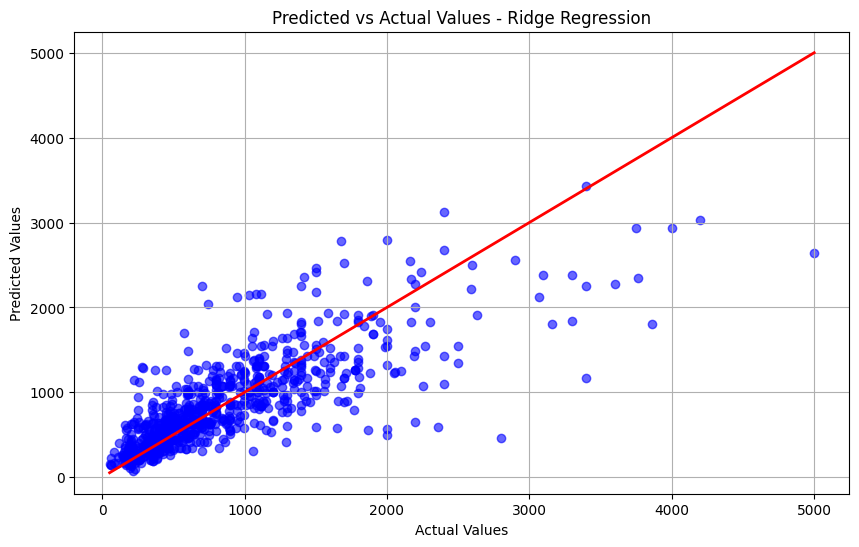

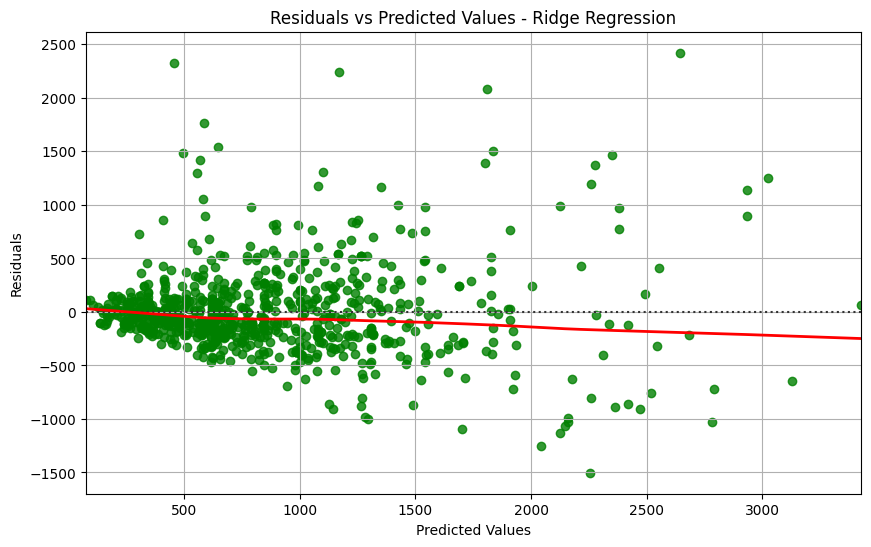

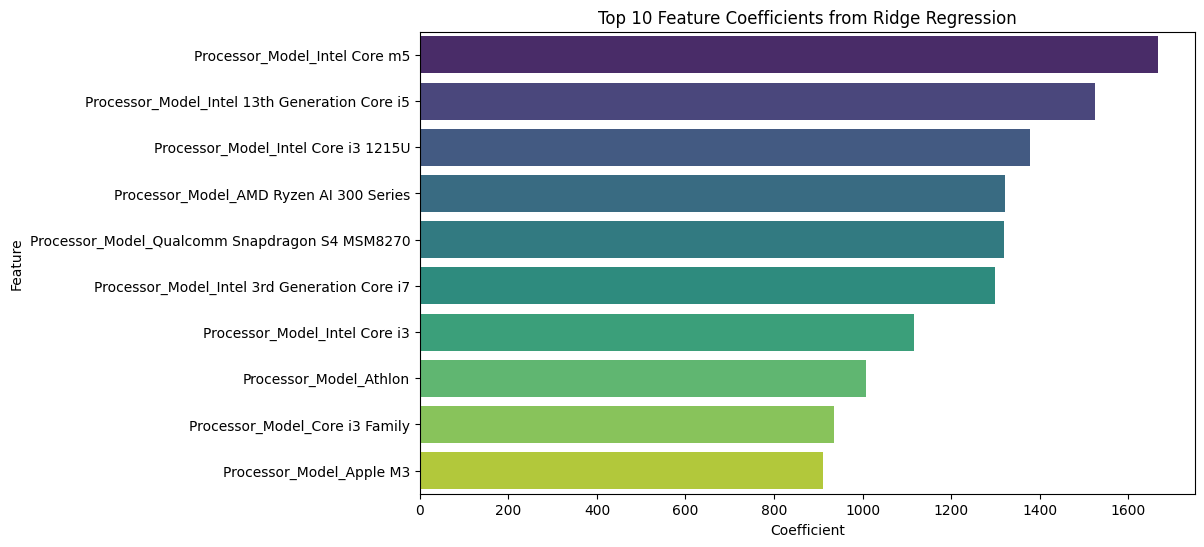

In [23]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, Ridge_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - Ridge Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - Ridge_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=Ridge_y_pred, y=residuals, lowess=True,color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - Ridge Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Feature Coefficients Plot (for Linear Regression)
coefficients = Ridge_pipeline.named_steps['regressor'].coef_

# Get the feature names from one-hot encoding (including numerical features)
cat_feature_names = Ridge_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(Ridgecategorical_cols)
all_feature_names = np.concatenate([cat_feature_names, Ridgenumerical_cols[:-1]])

# Prepare a DataFrame for better visualization of feature importance
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Number of top features to display
top_n = 10  

# Sort the coefficients by absolute value and get the top N features
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
top_coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(top_n)

# Plot top feature coefficients (importance)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coef_df, palette='viridis')
plt.title(f"Top {top_n} Feature Coefficients from Ridge Regression")
plt.show()

In [24]:
coef_df

,Feature,Coefficient,Absolute_Coefficient
306,Processor_Model_Intel Core m5,1667.618774,1667.618774
251,Processor_Model_Intel 13th Generation Core i5,1525.347631,1525.347631
291,Processor_Model_Intel Core i3 1215U,1378.346539,1378.346539
152,Processor_Model_AMD Ryzen AI 300 Series,1321.817320,1321.817320
345,Processor_Model_Qualcomm Snapdragon S4 MSM8270,1318.702702,1318.702702
...,...,...,...
41,Brand_KUU,-519.967023,519.967023
160,Processor_Model_Apple M1 Pro,-537.545711,537.545711
108,Processor_Model_1.6 GHz,-559.254348,559.254348
66,Brand_SAMSUNG,-606.770678,606.770678


In [25]:
y_pred_reg_models.append(Ridge_y_pred)

In [26]:
reg_model.append(ridge_regressor)

## 4.5 Lasso Regression

In [27]:
# Lasso Regression
from sklearn.linear_model import Lasso

# Define categorical and numerical columns
Lassocategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
Lassonumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
Lasso_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = Lasso_df_cleaned[Lassocategorical_cols + Lassonumerical_cols[:-1]]  # Exclude Price from features
y = Lasso_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), Lassonumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), Lassocategorical_cols)
    ]
)

# Create the Lasso Regression pipeline
lasso_regressor = Lasso(alpha=0.1)

Lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso_regressor)
])

# Fit the pipeline on the training data
Lasso_pipeline.fit(X_train, y_train)

# Predict on the test set
Lasso_y_pred = Lasso_pipeline.predict(X_test)

# Calculate RMSE
Lasso_mse = mean_squared_error(y_test, Lasso_y_pred)
Lasso_rmse = np.sqrt(Lasso_mse)

r2 = r2_score(y_test, Lasso_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': Lasso_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [Lasso_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,249.321928,299.00,398.009093,0.622207,0.619486
1,417.347376,455.88,398.009093,0.622207,0.619486
2,455.093251,407.15,398.009093,0.622207,0.619486
3,1096.833092,899.99,398.009093,0.622207,0.619486
4,381.101184,407.99,398.009093,0.622207,0.619486
...,...,...,...,...,...
835,200.340703,169.99,398.009093,0.622207,0.619486
836,620.335844,569.00,398.009093,0.622207,0.619486
837,207.641398,202.79,398.009093,0.622207,0.619486
838,1640.604077,1299.99,398.009093,0.622207,0.619486


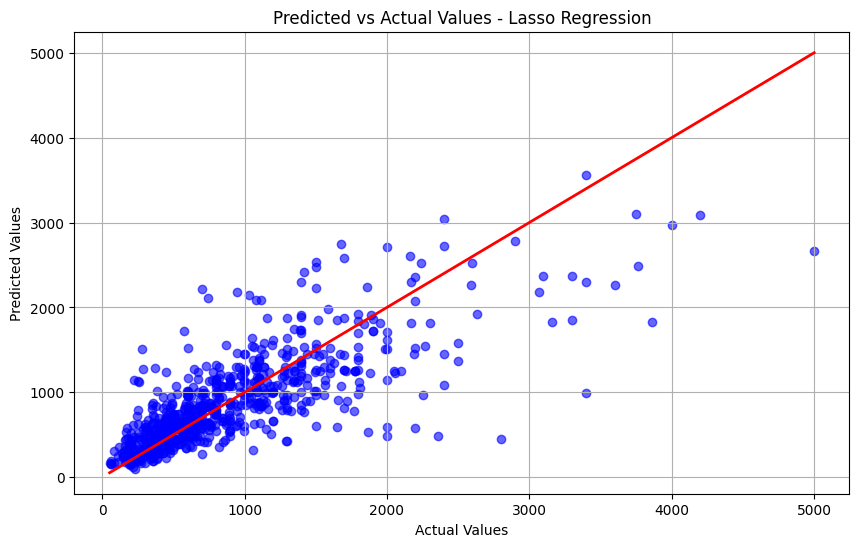

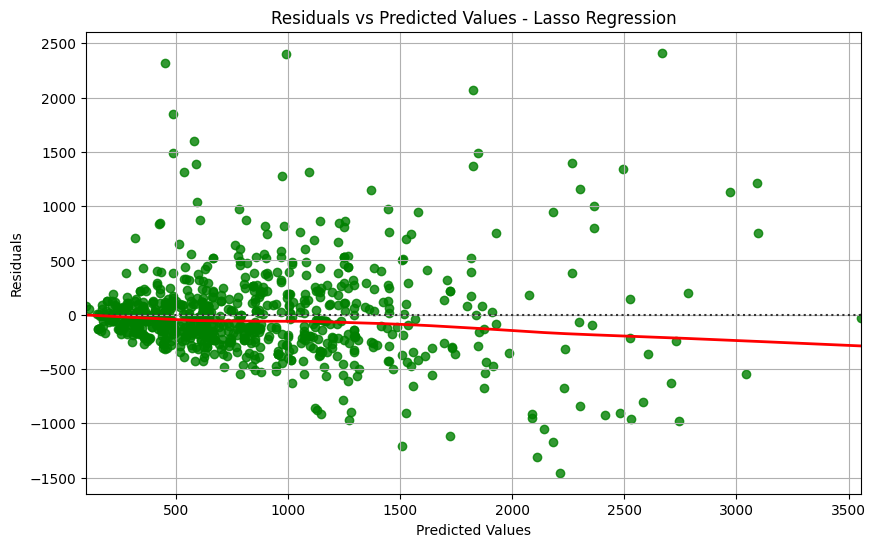

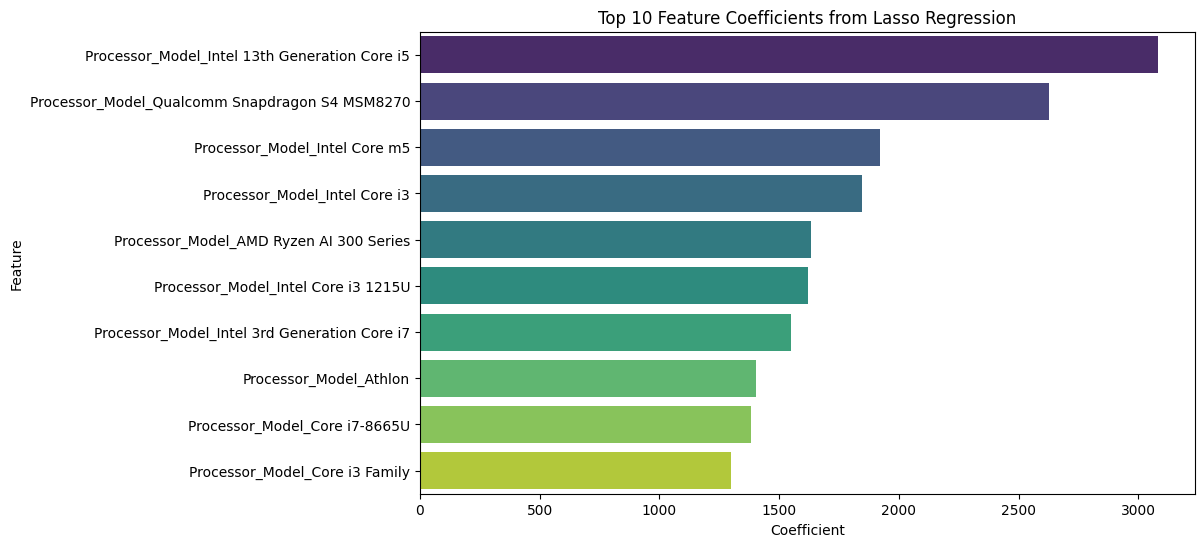

In [28]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, Lasso_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - Lasso Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - Lasso_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=Lasso_y_pred, y=residuals, lowess=True,color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - Lasso Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Feature Coefficients Plot (for Linear Regression)
coefficients = Lasso_pipeline.named_steps['regressor'].coef_

# Get the feature names from one-hot encoding (including numerical features)
cat_feature_names = Lasso_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(Lassocategorical_cols)
all_feature_names = np.concatenate([cat_feature_names, Lassonumerical_cols[:-1]])

# Prepare a DataFrame for better visualization of feature importance
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Number of top features to display
top_n = 10  

# Sort the coefficients by absolute value and get the top N features
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
top_coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(top_n)

# Plot top feature coefficients (importance)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coef_df, palette='viridis')
plt.title(f"Top {top_n} Feature Coefficients from Lasso Regression")
plt.show()

In [29]:
y_pred_reg_models.append(Lasso_y_pred)

In [30]:
reg_model.append(lasso_regressor)

## 4.6 RANSAC Regression

In [31]:
# RANSAC Regression
from sklearn.linear_model import RANSACRegressor

# Define categorical and numerical columns
RANSACcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
RANSACnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
RANSAC_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = RANSAC_df_cleaned[RANSACcategorical_cols + RANSACnumerical_cols[:-1]]  # Exclude Price from features
y = RANSAC_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), RANSACnumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), RANSACcategorical_cols)
    ]
)

# Create the RANSAC Regression pipeline
ransac_regressor = RANSACRegressor(estimator=LinearRegression(), random_state=42)

RANSAC_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ransac_regressor)
])

# Fit the pipeline on the training data
RANSAC_pipeline.fit(X_train, y_train)

# Predict on the test set
RANSAC_y_pred = RANSAC_pipeline.predict(X_test)

# Calculate RMSE
RANSAC_mse = mean_squared_error(y_test, RANSAC_y_pred)
RANSAC_rmse = np.sqrt(RANSAC_mse)

r2 = r2_score(y_test, RANSAC_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': RANSAC_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [RANSAC_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,256.029460,299.00,553.753437,0.268692,0.263424
1,433.231873,455.88,553.753437,0.268692,0.263424
2,407.134525,407.15,553.753437,0.268692,0.263424
3,1029.614248,899.99,553.753437,0.268692,0.263424
4,413.307138,407.99,553.753437,0.268692,0.263424
...,...,...,...,...,...
835,170.536934,169.99,553.753437,0.268692,0.263424
836,671.664431,569.00,553.753437,0.268692,0.263424
837,145.869839,202.79,553.753437,0.268692,0.263424
838,1836.826641,1299.99,553.753437,0.268692,0.263424


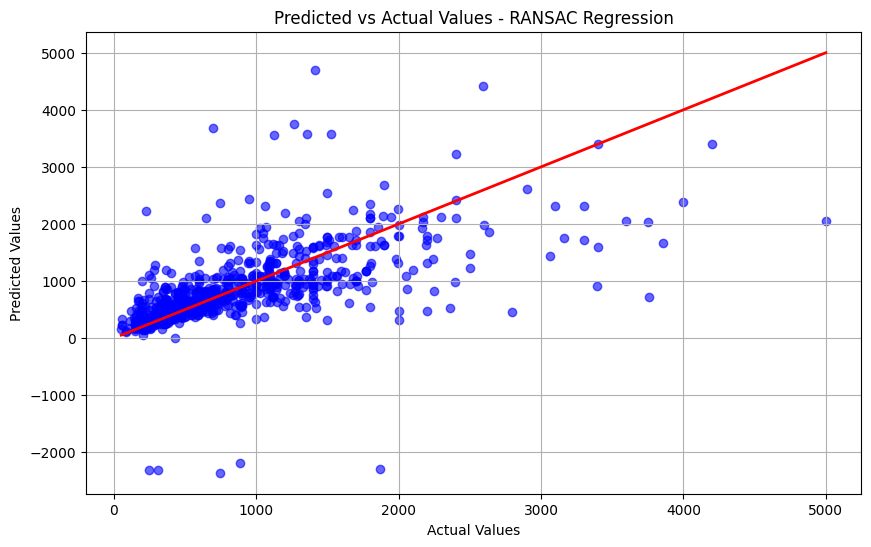

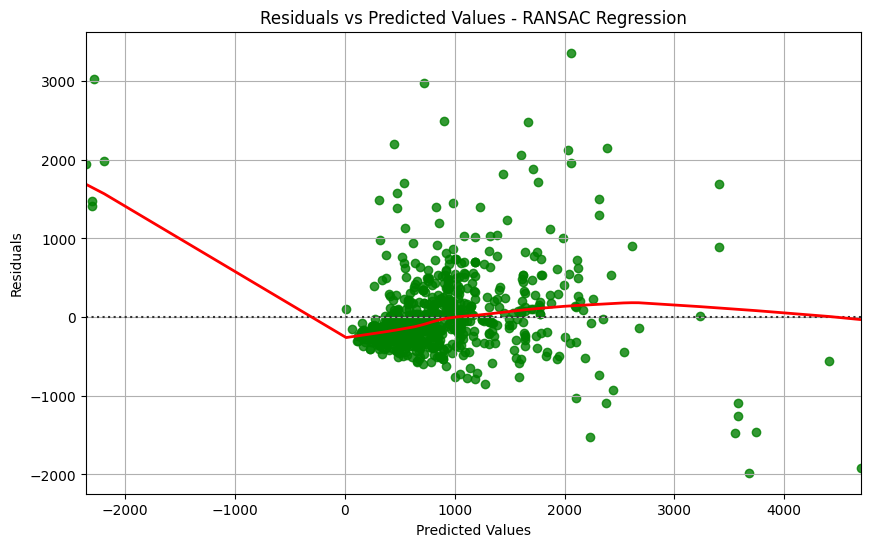

In [32]:
# Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, RANSAC_y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Identity line
plt.title("Predicted vs Actual Values - RANSAC Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Plot (Predicted values vs Residuals)
residuals = y_test - RANSAC_y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=RANSAC_y_pred, y=residuals, lowess=True,color="green", line_kws={'color': 'red', 'lw': 2})
plt.title("Residuals vs Predicted Values - RANSAC Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [33]:
y_pred_reg_models.append(RANSAC_y_pred)

In [34]:
reg_model.append(ransac_regressor)

## 4.7 SVM Regression

In [35]:
# SVM Regression
from sklearn.svm import SVR

# Define categorical and numerical columns
SVMcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
SVMnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
SVM_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = SVM_df_cleaned[SVMcategorical_cols + SVMnumerical_cols[:-1]]  # Exclude Price from features
y = SVM_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), SVMnumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), SVMcategorical_cols)  # Set sparse=False
    ]
)

# Create the SVM Regression pipeline
svm_regressor = SVR(kernel='rbf')

SVM_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', svm_regressor)
])

# Fit the pipeline on the training data
SVM_pipeline.fit(X_train, y_train)

# Predict on the test set
SVM_y_pred = SVM_pipeline.predict(X_test)

# Calculate RMSE
SVM_mse = mean_squared_error(y_test, SVM_y_pred)
SVM_rmse = np.sqrt(SVM_mse)

r2 = r2_score(y_test, SVM_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': SVM_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [SVM_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,559.061532,299.00,637.245675,0.031541,0.024565
1,523.624773,455.88,637.245675,0.031541,0.024565
2,665.821016,407.15,637.245675,0.031541,0.024565
3,637.065809,899.99,637.245675,0.031541,0.024565
4,517.267645,407.99,637.245675,0.031541,0.024565
...,...,...,...,...,...
835,537.737800,169.99,637.245675,0.031541,0.024565
836,617.083482,569.00,637.245675,0.031541,0.024565
837,564.972257,202.79,637.245675,0.031541,0.024565
838,650.791588,1299.99,637.245675,0.031541,0.024565


In [36]:
y_pred_reg_models.append(SVM_y_pred)

In [37]:
reg_model.append(svm_regressor)

## 4.8 Random Forest Regression

In [38]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Define categorical and numerical columns
RandomForestcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
RandomForestnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
RandomForest_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = RandomForest_df_cleaned[RandomForestcategorical_cols + RandomForestnumerical_cols[:-1]]  # Exclude Price from features
y = RandomForest_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), RandomForestnumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), RandomForestcategorical_cols)
    ]
)

# Create the Random Forest Regression pipeline
random_forest_regressor = RandomForestRegressor(random_state=42)

RandomForest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', random_forest_regressor)
])

# Fit the pipeline on the training data
RandomForest_pipeline.fit(X_train, y_train)

# Predict on the test set
RandomForest_y_pred = RandomForest_pipeline.predict(X_test)

# Calculate RMSE
RandomForest_mse = mean_squared_error(y_test, RandomForest_y_pred)
RandomForest_rmse = np.sqrt(RandomForest_mse)

r2 = r2_score(y_test, RandomForest_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': RandomForest_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [RandomForest_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,299.390621,299.00,355.926994,0.697873,0.695697
1,449.305935,455.88,355.926994,0.697873,0.695697
2,407.150000,407.15,355.926994,0.697873,0.695697
3,936.228584,899.99,355.926994,0.697873,0.695697
4,399.544823,407.99,355.926994,0.697873,0.695697
...,...,...,...,...,...
835,174.727033,169.99,355.926994,0.697873,0.695697
836,722.291945,569.00,355.926994,0.697873,0.695697
837,271.063000,202.79,355.926994,0.697873,0.695697
838,1454.186822,1299.99,355.926994,0.697873,0.695697


In [39]:
y_pred_reg_models.append(RandomForest_y_pred)

In [40]:
reg_model.append(random_forest_regressor)

## 4.9 GBDT Regression

In [41]:
# GBDT Regression
from sklearn.ensemble import GradientBoostingRegressor

# Define categorical and numerical columns
GBDTcategorical_cols = ['Brand', 'Processor_Brand', 'Storage_Type', 'Processor_Model']
GBDTnumerical_cols = ['Storage_Capacity(GB)', 'RAM(GB)', 'Price']

# Clean the DataFrame by dropping rows where 'Price' is missing
GBDT_df_cleaned = laptop_df.dropna(subset=['Price'])

# Define features (X) and target (y)
X = GBDT_df_cleaned[GBDTcategorical_cols + GBDTnumerical_cols[:-1]]  # Exclude Price from features
y = GBDT_df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the preprocessor with numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), GBDTnumerical_cols[:-1]), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), GBDTcategorical_cols)
    ]
)

# Create the GBDT Regression pipeline
gbdt_regressor = GradientBoostingRegressor(random_state=42)

GBDT_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gbdt_regressor)
])

# Fit the pipeline on the training data
GBDT_pipeline.fit(X_train, y_train)

# Predict on the test set
GBDT_y_pred = GBDT_pipeline.predict(X_test)

# Calculate RMSE
GBDT_mse = mean_squared_error(y_test, GBDT_y_pred)
GBDT_rmse = np.sqrt(GBDT_mse)

r2 = r2_score(y_test, GBDT_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': GBDT_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [GBDT_rmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,512.720933,299.00,387.55825,0.641787,0.639207
1,462.750300,455.88,387.55825,0.641787,0.639207
2,826.771050,407.15,387.55825,0.641787,0.639207
3,873.482928,899.99,387.55825,0.641787,0.639207
4,384.361598,407.99,387.55825,0.641787,0.639207
...,...,...,...,...,...
835,261.382028,169.99,387.55825,0.641787,0.639207
836,696.300920,569.00,387.55825,0.641787,0.639207
837,308.616856,202.79,387.55825,0.641787,0.639207
838,1230.115323,1299.99,387.55825,0.641787,0.639207


In [42]:
y_pred_reg_models.append(GBDT_y_pred)

In [43]:
reg_model.append(gbdt_regressor)

## 4.10 XGBoost Regression

In [44]:
# XGBoost Regression
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(random_state=42)


# Full pipeline with preprocessing and model
XGBoost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

# Fit the model
XGBoost_pipeline.fit(X_train, y_train)

# Make predictions on the test set
XGBoost_y_pred = XGBoost_pipeline.predict(X_test)

# Evaluate the model
XGBmse = mean_squared_error(y_test, XGBoost_y_pred)
XGBrmse = np.sqrt(XGBmse)

r2 = r2_score(y_test, XGBoost_y_pred) 
# Calculate the adjusted R² score 
n = len(y_test) # number of observations 
p = X_test.shape[1] # number of predictors 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) 

# Create a DataFrame with the predicted values, actual values, RMSE value, R² score, and adjusted R² score 
results_df = pd.DataFrame({'Predicted Values': XGBoost_y_pred, 
                           'Actual Values': y_test.values, 
                           'RMSE Value': [XGBrmse] * len(y_test), 
                           'R² Score': [r2] * len(y_test), 
                           'Adjusted R² Score': [adjusted_r2] * len(y_test) })

results_df

,Predicted Values,Actual Values,RMSE Value,R² Score,Adjusted R² Score
0,311.609680,299.00,338.35176,0.726974,0.725007
1,426.125000,455.88,338.35176,0.726974,0.725007
2,497.794922,407.15,338.35176,0.726974,0.725007
3,932.421875,899.99,338.35176,0.726974,0.725007
4,377.491791,407.99,338.35176,0.726974,0.725007
...,...,...,...,...,...
835,211.097153,169.99,338.35176,0.726974,0.725007
836,698.585022,569.00,338.35176,0.726974,0.725007
837,238.335617,202.79,338.35176,0.726974,0.725007
838,1309.299072,1299.99,338.35176,0.726974,0.725007


In [45]:
y_pred_reg_models.append(XGBoost_y_pred)

In [46]:
reg_model.append(xgb_regressor)

# 5. Model Evaluation

In [47]:
# First evaluating with MSE in order to identify the best models
from sklearn.metrics import mean_squared_error

mse_values = []


# for each model computing the MSE
for y_pred in y_pred_reg_models:
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

mse_df = pd.DataFrame({'Model': reg_model,'MSE': mse_values})

mse_df = mse_df.sort_values(by='MSE')

mse_df

,Model,MSE
9,"XGBRegressor(base_score=None, booster=None, ca...",114481.913737
7,"(DecisionTreeRegressor(max_features=1.0, rando...",126684.025360
2,LinearRegression(),149133.760923
8,([DecisionTreeRegressor(criterion='friedman_ms...,150201.396966
0,KNeighborsRegressor(),150855.960882
3,Ridge(),157768.398214
4,Lasso(alpha=0.1),158411.238343
1,DecisionTreeRegressor(random_state=42),161633.205063
5,"RANSACRegressor(estimator=LinearRegression(), ...",306642.868986
6,SVR(),406082.050035


In [48]:
import re

# Function to extract model name from the 'Model' column
def extract_model_name(model):
    
    # Extracts the model name before the first '(' if present
    return re.split(r'\(', str(model))[0]

mse_df['Model Name'] = mse_df['Model'].apply(extract_model_name)

# Reorder the columns to have 'Model Name' as the first column
mse_df = mse_df[['Model Name', 'Model', 'MSE']]

mse_df

,Model Name,Model,MSE
9,XGBRegressor,"XGBRegressor(base_score=None, booster=None, ca...",114481.913737
7,RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",126684.025360
2,LinearRegression,LinearRegression(),149133.760923
8,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,150201.396966
0,KNeighborsRegressor,KNeighborsRegressor(),150855.960882
3,Ridge,Ridge(),157768.398214
4,Lasso,Lasso(alpha=0.1),158411.238343
1,DecisionTreeRegressor,DecisionTreeRegressor(random_state=42),161633.205063
5,RANSACRegressor,"RANSACRegressor(estimator=LinearRegression(), ...",306642.868986
6,SVR,SVR(),406082.050035


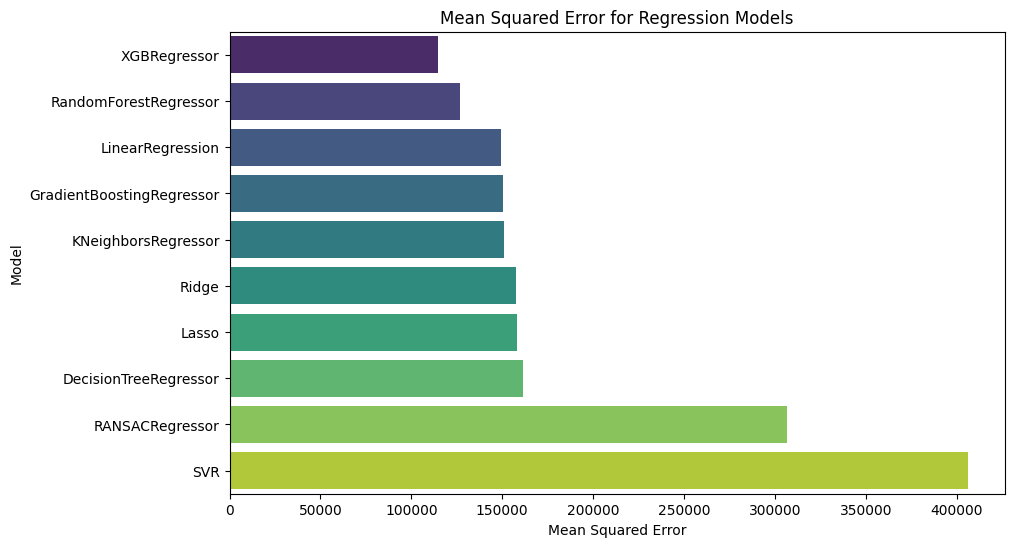

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='MSE', y='Model Name', data=mse_df, hue="Model Name", palette='viridis')
plt.title('Mean Squared Error for Regression Models')
plt.xlabel('Mean Squared Error')
plt.ylabel('Model')
plt.show()

In [54]:
# Computing R2 Scores and Adjusted R2 Scores to check how good the model is in reality
from sklearn.metrics import r2_score

top_models_df = mse_df.head(3)

r2_scores = []
adj_r2_scores = []

n = len(y_test)  

for i, row in top_models_df.iterrows():

    model_name = row['Model']
    
    # Get the index of the model based on its name
    model_index = reg_model.index(model_name)  
    y_pred = y_pred_reg_models[model_index]  # Retrieve the predictions for the model
    
    # Calculate R² Score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # Calculate Adjusted R² Score
    p = X.shape[1]  # number of features
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    adj_r2_scores.append(adj_r2)


top_reg_model = pd.DataFrame({
    'Model_Name': top_models_df['Model'],
    'MSE_Value': top_models_df['MSE'],
    'R2_Score': r2_scores,
    'adjR2_Score': adj_r2_scores
})

top_reg_model["Models"] = top_reg_model['Model_Name'].apply(extract_model_name) 

# Reorder the columns to have 'Model Name' as the first column
top_reg_model = top_reg_model[['Models','Model_Name','MSE_Value','R2_Score','adjR2_Score']]

top_reg_model

,Models,Model_Name,MSE_Value,R2_Score,adjR2_Score
9,XGBRegressor,"XGBRegressor(base_score=None, booster=None, ca...",114481.913737,0.726974,0.725007
7,RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",126684.025360,0.697873,0.695697
2,LinearRegression,LinearRegression(),149133.760923,0.644333,0.641771


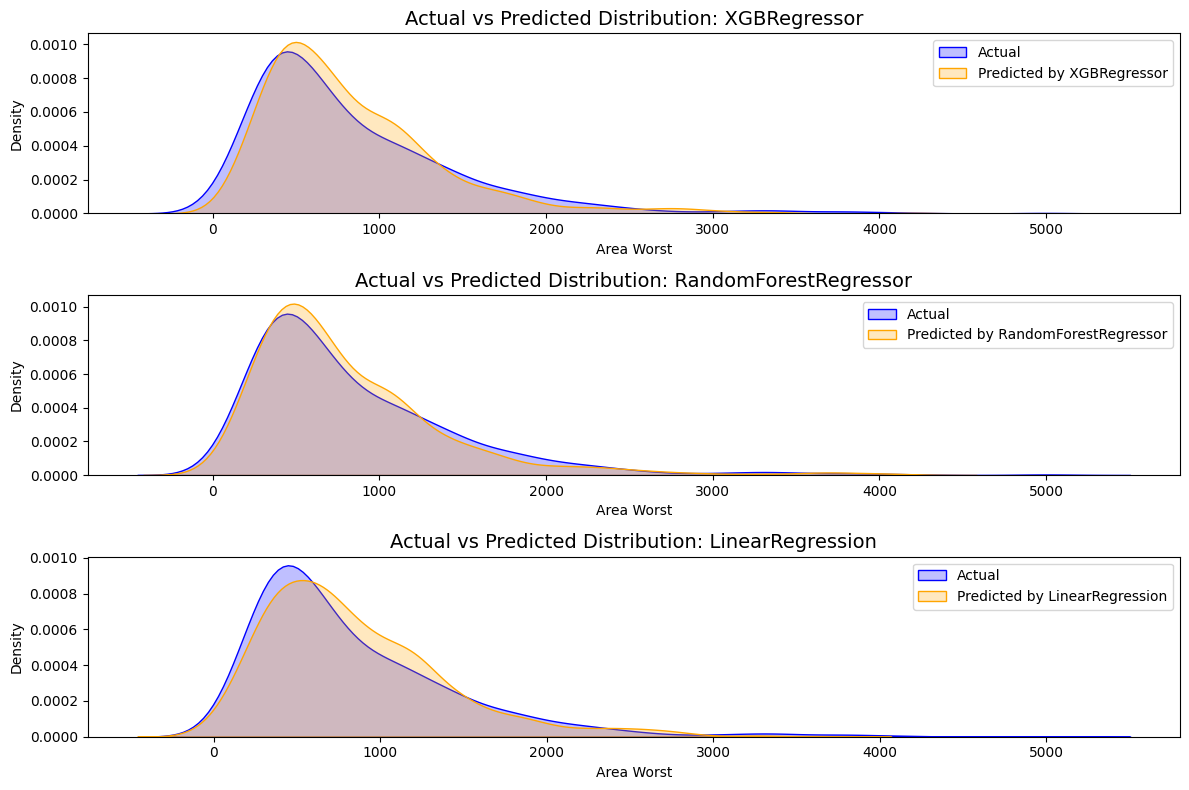

In [55]:
top_3_models = top_reg_model['Models'].tolist()

# Prepare figure
plt.figure(figsize=(12, 8))

# Plot KDE for each model
for i, model_name in enumerate(top_3_models):
    plt.subplot(3, 1, i + 1)
    
    # Get the actual and predicted values for each model
    y_pred = y_pred_reg_models[i]  # Adjust index based on how you store the predictions
    
    # KDE plot of actual vs predicted values
    sns.kdeplot(y_test, label='Actual', color='blue', fill=True)
    sns.kdeplot(y_pred, label=f'Predicted by {model_name}', color='orange', fill=True)
    
    # Plot settings
    plt.title(f'Actual vs Predicted Distribution: {model_name}', fontsize=14)
    plt.xlabel('Area Worst')
    plt.ylabel('Density')
    plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# 6. Hyperparameter Tuning Top 3 Performing Models

In [ ]:
# TODO: Skeleton Code to be Added post Model Training